In [1]:
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages

import os


In [2]:
import pandas
from pystain import StainDataset
subject_id = 15035

ds = StainDataset(subject_id)

subject_ids = [13095, 14037, 14051, 14069, 15033, 15035, 15055]
conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                      [-ds.z_resolution, 0, 0],
                      [0, -ds.xy_resolution, 0]])


/home/gdholla1/data/post_mortem/new_data_format/15035/images.hdf5


In [3]:
results = []




for subject_id in subject_ids[:]:


    ds = StainDataset(subject_id, fwhm=0.3)
    
    
    # Get coordinates of mask and bring them to mm
    x, y, z = np.where(ds.thresholded_mask)
    coords = np.column_stack((x, y, z))

    coords_mm = conversion_matrix.dot(coords.T).T
    coords_mm -= coords_mm.mean(0)
    
    
    # Fit two components and make sure first axis walks dorsal
    # and second component lateral
    pca = PCA()
    pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

    components = pca.components_
    print components

    if components[0, 1] < 0:
        components[0] = -components[0]

    if components[1, 0] < 0:
        components[1] = -components[1]
        
    print components
        
    coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
    coords_dataframe['slice'] = x

    coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
    coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

    coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())
    
    coords_dataframe['slice_3'] = pandas.qcut(coords_dataframe.y_mm, 3, labels=['posterior', 'middle', 'anterior'])    

    coords_dataframe['pc1_3'] = coords_dataframe.groupby('slice_3').pc1.apply(lambda d: pandas.qcut(d, 3, labels=['ventral', 'middle', 'dorsal']))
    coords_dataframe['pc2_3'] = coords_dataframe.groupby(['slice_3', 'pc1_3']).pc2.apply(lambda d: pandas.qcut(d, 3, labels=['medial', 'middle', 'lateral']))

    
    df= pandas.concat((ds.smoothed_dataframe, coords_dataframe), 1)
    tmp = df.pivot_table(index=['pc1_3', 'pc2_3', 'slice_3'], values=ds.stains, aggfunc='mean').copy()
    tmp['subject_id'] = subject_id
    
    results.append(tmp.copy())

/home/gdholla1/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.97056185 -0.24085203]
 [-0.24085203  0.97056185]]
[[ 0.97056185  0.24085203]
 [ 0.24085203 -0.97056185]]
/home/gdholla1/data/post_mortem/new_data_format/14037/images.hdf5
[[-0.95649419 -0.29175138]
 [ 0.29175138 -0.95649419]]
[[ 0.95649419  0.29175138]
 [ 0.29175138 -0.95649419]]
/home/gdholla1/data/post_mortem/new_data_format/14051/images.hdf5
[[-0.78933812 -0.61395874]
 [ 0.61395874 -0.78933812]]
[[ 0.78933812  0.61395874]
 [ 0.61395874 -0.78933812]]
/home/gdholla1/data/post_mortem/new_data_format/14069/images.hdf5
[[-0.70764237 -0.70657079]
 [ 0.70657079 -0.70764237]]
[[ 0.70764237  0.70657079]
 [ 0.70657079 -0.70764237]]
/home/gdholla1/data/post_mortem/new_data_format/15033/images.hdf5
[[-0.66358108 -0.74810437]
 [ 0.74810437 -0.66358108]]
[[ 0.66358108  0.74810437]
 [ 0.74810437 -0.66358108]]
/home/gdholla1/data/post_mortem/new_data_format/15035/images.hdf5
[[-0.61137631 -0.79134   ]
 [-0.79134     0.61137631]]

In [5]:
df = pandas.concat(results).reset_index().set_index(['subject_id', 'slice_3', 'pc1_3', 'pc2_3'])
df = pandas.melt(df.reset_index(), id_vars=['subject_id', 'slice_3', 'pc1_3', 'pc2_3'], var_name='stain')
df['value'] = df.groupby(['subject_id', 'stain']).transform(lambda x: (x - x.mean()) / x.std())

In [6]:
def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, **kwargs):

    ''' values is a n-by-m array'''
    

    if ellipse_pars is None:
        a = 350
        b = 150
        x = 500
        y= 500

        theta = 45. / 180 * np.pi

    else:
        a, b, x, y, theta = ellipse_pars

    A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2 * A * x - B* y
    E = -B * x - 2 * C * y
    F = A* x**2 + B*x*y + C*y**2 - a**2*b**2


    X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0


    pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
    pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

    pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
    pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

    pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
    pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

    im = np.zeros_like(X, dtype=float)

    for pc1_q in np.arange(values.shape[0]):
        for pc2_q in np.arange(values.shape[1]):
            im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]


    # im[in_ellipse * (pc1_distance < 0) & (pc2_distance < 0)] = lower_left
    # im[in_ellipse * (pc1_distance < 0) & (pc2_distance > 0)] = lower_right

    im = np.ma.masked_array(im, ~in_ellipse)
    cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    plt.grid('off')
    sns.despine()
    
    return cax

In [7]:
from statsmodels.sandbox.stats import multicomp
from matplotlib import patches


In [8]:
sns.set_style('white')

In [9]:
df.stain.unique()

array(['CALR', 'FER', 'GABRA3', 'GAD6567', 'MBP', 'PARV', 'SERT', 'SMI32',
       'SYN', 'TH', 'TRANSF', 'VGLUT1'], dtype=object)

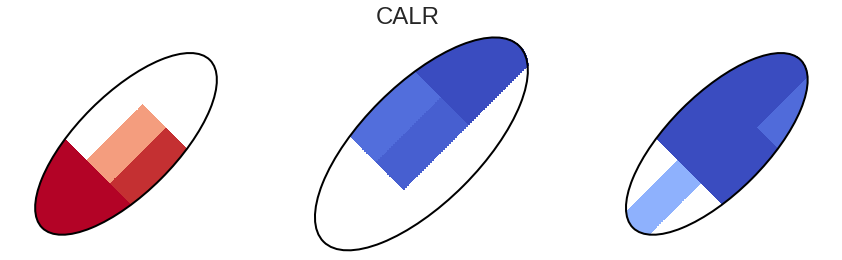

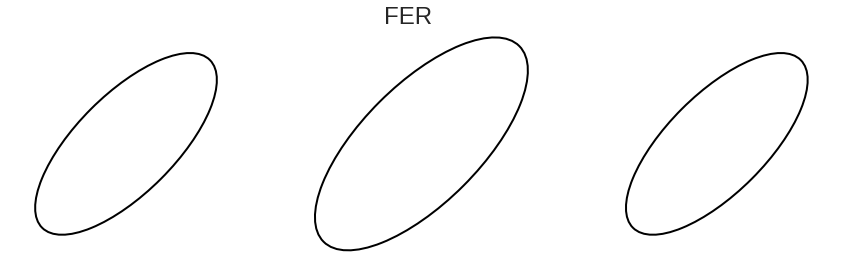

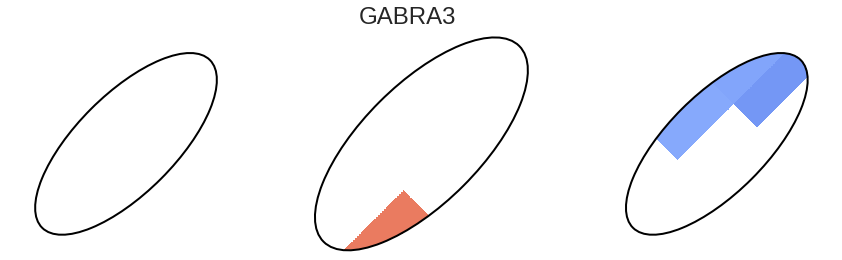

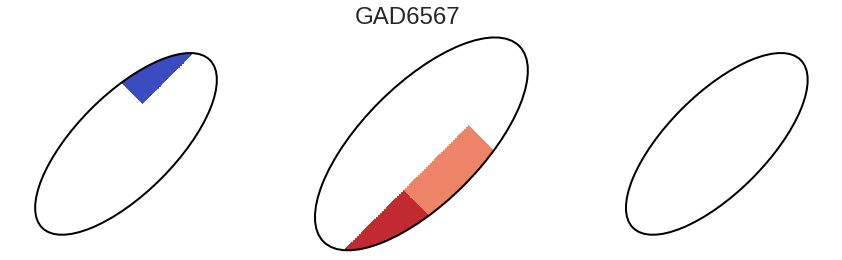

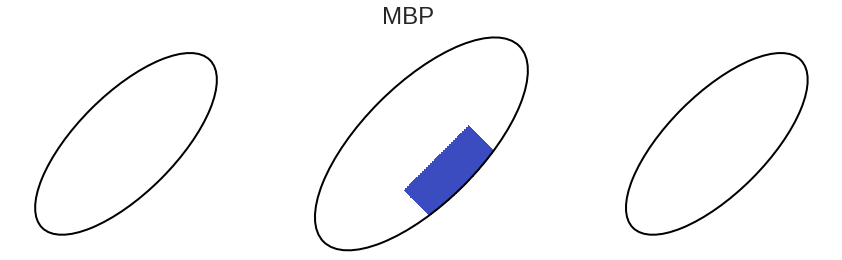

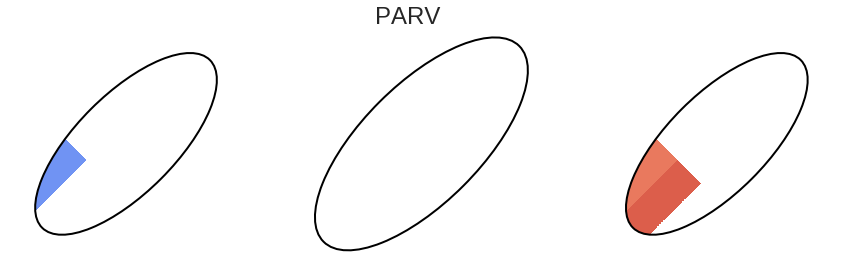

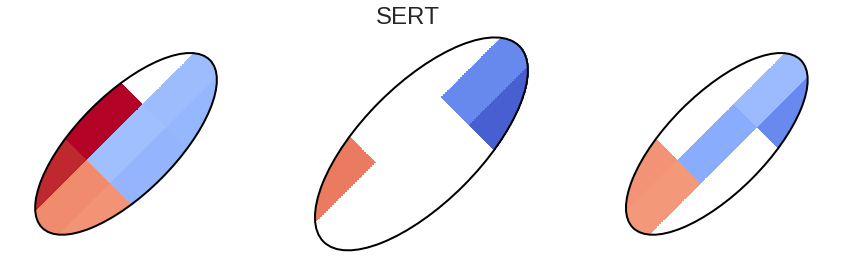

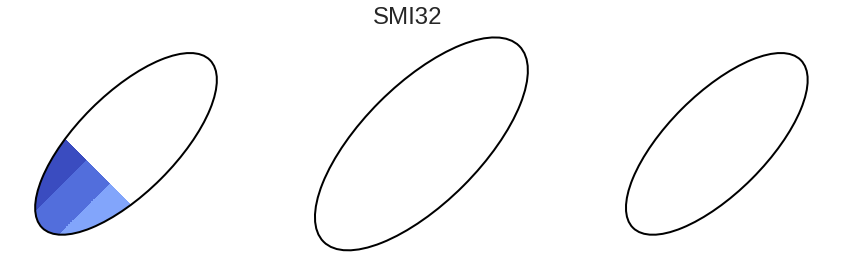

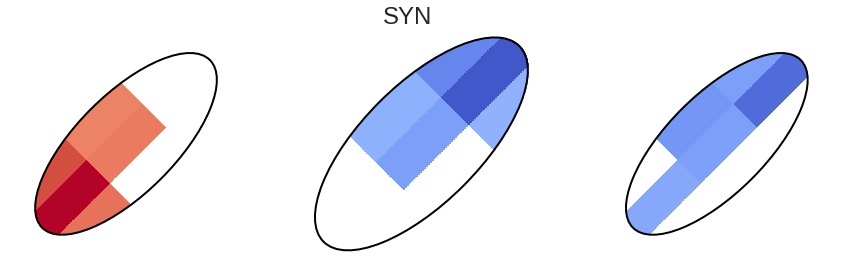

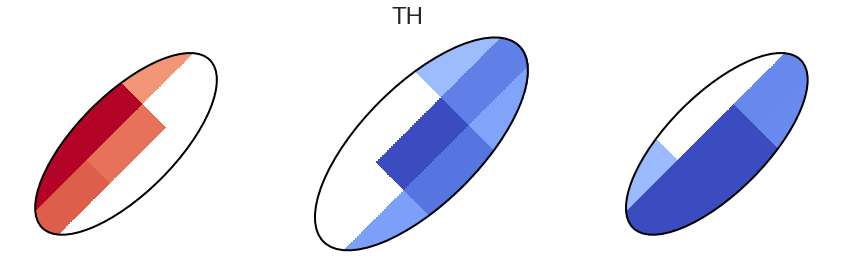

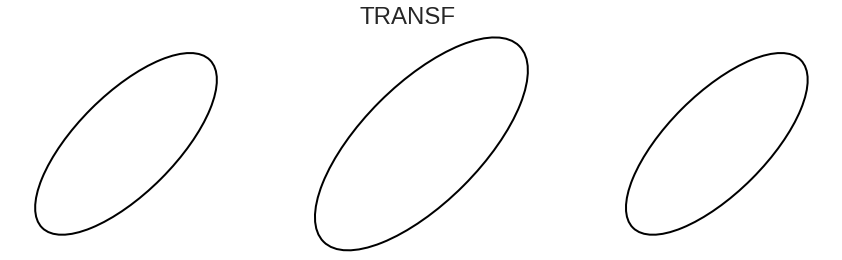

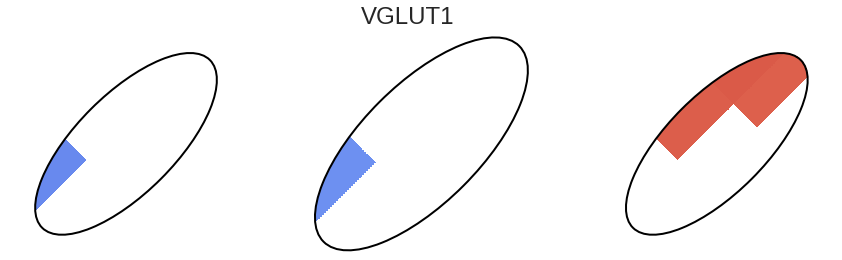

In [12]:
for stain, d in df.groupby(['stain']):
    
    fn = '/home/gdholla1/projects/post_mortem/reports/PCA_sectors/{stain}_big_picture_coolwarm.pdf'.format(**locals())
    pdf = PdfPages(fn)
    
    fig, axes = plt.subplots(nrows=1, ncols=3)
    
    for i, (slice, d2) in enumerate(d.groupby('slice_3')):
    
        ax = plt.subplot(1, 3, ['anterior', 'middle', 'posterior'].index(slice) + 1)
        
        n = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: len(v)).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        t = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0)[0]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        p = d2.groupby(['pc1_3', 'pc2_3']).value.apply(lambda v: sp.stats.ttest_1samp(v, 0)[1]).unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        mean = d2.groupby(['pc1_3', 'pc2_3']).value.mean().unstack(1).ix[['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
        
        # FDR
        p.values[:] = multicomp.fdrcorrection0(p.values.ravel())[1].reshape(3, 3)
        
        if i == 1:
            a, b, x, y, theta  = 350, 150, 300, 275, 45
        else:
            a, b, x, y, theta  = 300, 125, 300, 275, 45.

        plot_ellipse_values(t[p<0.05].values, size=(600, 550), ellipse_pars=(a, b, x, y,  theta / 180. * np.pi), vmin=-7, vmax=7, cmap=plt.cm.coolwarm)


        e1 = patches.Ellipse((x, y), a*2, b*2,
                         angle=theta, linewidth=2, fill=False, zorder=2)

        ax.add_patch(e1)

        plt.xticks([])
        plt.yticks([])    

        sns.despine(bottom=True, left=True)



        sns.despine(bottom=True, left=True)

    plt.suptitle(stain, fontsize=24)
    fig.set_size_inches(15., 4.)
    pdf.savefig(fig, transparent=True)    
    pdf.close()

In [18]:
t

pc2_3,medial,middle,lateral
pc1_3,,,
ventral,0.158107,-0.423532,-0.827831
middle,5.275059,1.494336,0.672221
dorsal,5.395954,5.219260,1.214091
